# Transfer Learning for Images, Videos, and Audio (Feature Extraction + Fine-Tuning)

# Image

In [1]:
!pip install -q tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 595.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.0 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.datasets import cifar10

# load CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# filter classes
train_mask = np.isin(y_train, [3, 5]).flatten()
test_mask = np.isin(y_test, [3, 5]).flatten()

x_train, y_train = x_train[train_mask], y_train[train_mask]
x_test, y_test = x_test[test_mask], y_test[test_mask]

# binary labels: cat=0, dog=1
y_train = (y_train == 5).astype(np.int32)
y_test = (y_test == 5).astype(np.int32)

# resize and normalize
IMG_SIZE = 160
x_train = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE)) / 255.0
x_test = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE)) / 255.0

In [4]:
# build feature extractor model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# complie the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 137ms/step - accuracy: 0.7362 - loss: 0.5012 - val_accuracy: 0.8225 - val_loss: 0.3834
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.8427 - loss: 0.3520 - val_accuracy: 0.8210 - val_loss: 0.4043
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.8524 - loss: 0.3352 - val_accuracy: 0.8330 - val_loss: 0.3695


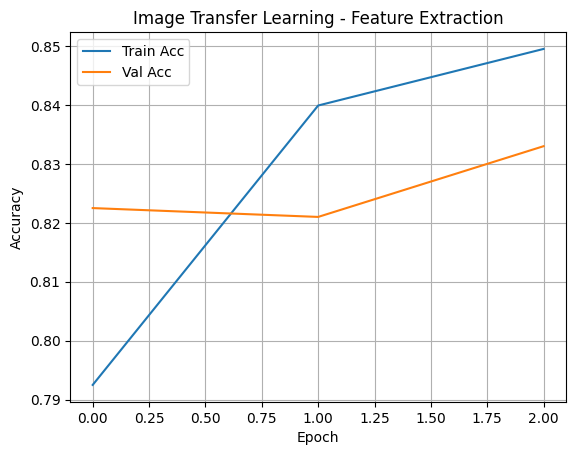

In [7]:
# image training visualization
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Image Transfer Learning - Feature Extraction")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# unfreeze top 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
fine_tune_history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 167ms/step - accuracy: 0.7928 - loss: 0.4482 - val_accuracy: 0.8325 - val_loss: 0.4041
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 160ms/step - accuracy: 0.8453 - loss: 0.3407 - val_accuracy: 0.8300 - val_loss: 0.4195
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 51s 164ms/step - accuracy: 0.8716 - loss: 0.3057 - val_accuracy: 0.8395 - val_loss: 0.3876


# Video

In [10]:
from tensorflow.keras.layers import TimeDistributed, LSTM

# parameters
NUM_VIDEOS = 50
FRAMES = 4
IMG_SIZE = 128

# load raw frames
(x, y), _ = cifar10.load_data()
x = tf.image.resize(x[:NUM_VIDEOS * FRAMES], (IMG_SIZE, IMG_SIZE)) / 255.0
y = y[:NUM_VIDEOS * FRAMES]

# assemble into videos
videos = tf.reshape(x, (-1, FRAMES, IMG_SIZE, IMG_SIZE, 3))
labels = tf.reshape(y, (-1, FRAMES))[:, 0]
labels = tf.cast(labels >= 5, tf.int32)

In [11]:
# build video model
cnn = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
cnn.trainable = False

video_model = Sequential([
    TimeDistributed(cnn),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# complie the model
video_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
video_model.fit(videos, labels, epochs=3, batch_size=4)

Epoch 1/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.5305 - loss: 0.7684
Epoch 2/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8019 - loss: 0.5830
Epoch 3/3
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9145 - loss: 0.4636


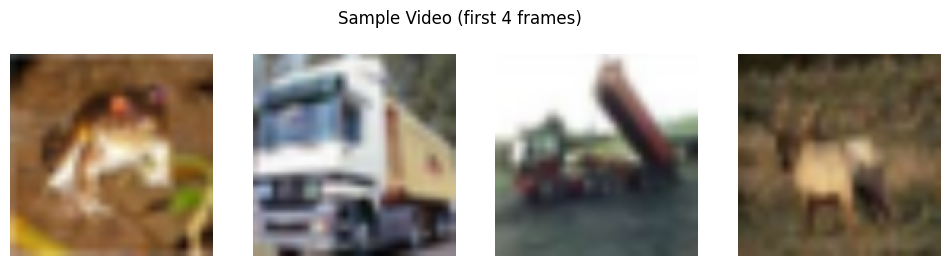

In [14]:
# preview video frames
fig, axes = plt.subplots(1, FRAMES, figsize=(12, 3))
for i in range(FRAMES):
    axes[i].imshow(videos[0, i])
    axes[i].axis('off')
plt.suptitle("Sample Video (first 4 frames)")
plt.show()

# Audio

In [16]:
!pip install -q tensorflow_datasets tensorflow_hub
!pip install -q pydub tensorflow-datasets tensorflow-hub
!apt-get install -qq ffmpeg

import tensorflow_datasets as tfds
import tensorflow_hub as hub

# load audio data
yamnet = hub.load("https://tfhub.dev/google/yamnet/1")
ds = tfds.load("speech_commands", split="train[:1%]")

# prepare dataset
X, y = [], []
for i, example in enumerate(ds.take(100)):
    waveform = tf.cast(example["audio"], tf.float32)
    _, embeddings, _ = yamnet(waveform)
    X.append(tf.reduce_mean(embeddings, axis=0).numpy())
    y.append(i % 2)

X = np.array(X)
y = np.array(y)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.7W78G6_0.0.3/speech_commands-train.tfrecord*...…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.7W78G6_0.0.3/speech_commands-validation.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/speech_commands/incomplete.7W78G6_0.0.3/speech_commands-test.tfrecord*...:…

Dataset speech_commands downloaded and prepared to /root/tensorflow_datasets/speech_commands/0.0.3. Subsequent calls will reuse this data.


In [17]:
# train classifier
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])




In [18]:
# complie the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
hist = model.fit(X, y, epochs=5)

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4670 - loss: 5.9486 
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4024 - loss: 9.0021
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5042 - loss: 11.9021
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5010 - loss: 5.3770
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5473 - loss: 7.1767


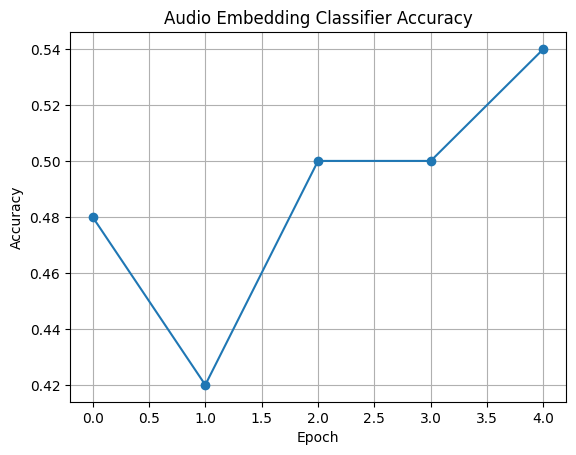

In [20]:
# Audio Training Visualization
plt.plot(hist.history['accuracy'], marker='o')
plt.title("Audio Embedding Classifier Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()